In [88]:
import pandas as pd
import geopandas as gpd
import numpy as np 
from numpy import log
import gmaps 
import gmaps.datasets 
import matplotlib.pyplot as plt
from datetime import datetime
plt.style.use('ggplot')
from sorted_months_weekdays import Month_Sorted_Month

# Arima class
from statsmodels.compat.pandas import Appender

import warnings

from sklearn.model_selection import TimeSeriesSplit
from sklearn.cluster import KMeans

from mpl_toolkits.mplot3d import Axes3D

from statsmodels.tools.data import _is_using_pandas
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.statespace.kalman_filter import MEMORY_CONSERVE
from statsmodels.tsa.statespace.tools import diff
import statsmodels.base.wrapper as wrap
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima.estimators.yule_walker import yule_walker
from statsmodels.tsa.arima.estimators.burg import burg
from statsmodels.tsa.arima.estimators.hannan_rissanen import hannan_rissanen
from statsmodels.tsa.arima.estimators.innovations import (
    innovations, innovations_mle)
from statsmodels.tsa.arima.estimators.gls import gls as estimate_gls

from statsmodels.tsa.arima.specification import SARIMAXSpecification
import statsmodels.api
import statsmodels as sm
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

import itertools

from pmdarima.utils import diff_inv


<h4>Load diffed and undiffed electrical consumption data</h4>

In [89]:
# load stationary consumption data from EDA notebook (diffed 2x)
diffed = pd.read_csv('stationary-data/diffed_data.csv').set_index('Date')

In [90]:
# load undiffed consumption data from EDA notebook (not diffed)
cov_rem = pd.read_csv('stationary-data/cov_rem.csv').set_index('Date')

In [91]:
diffed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95 entries, 2012-03-31 to 2020-01-31
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   avg_kwh_capita  95 non-null     float64
dtypes: float64(1)
memory usage: 1.5+ KB


<h4>Perform Trend-Seasonal-Residual decomposition</h4>

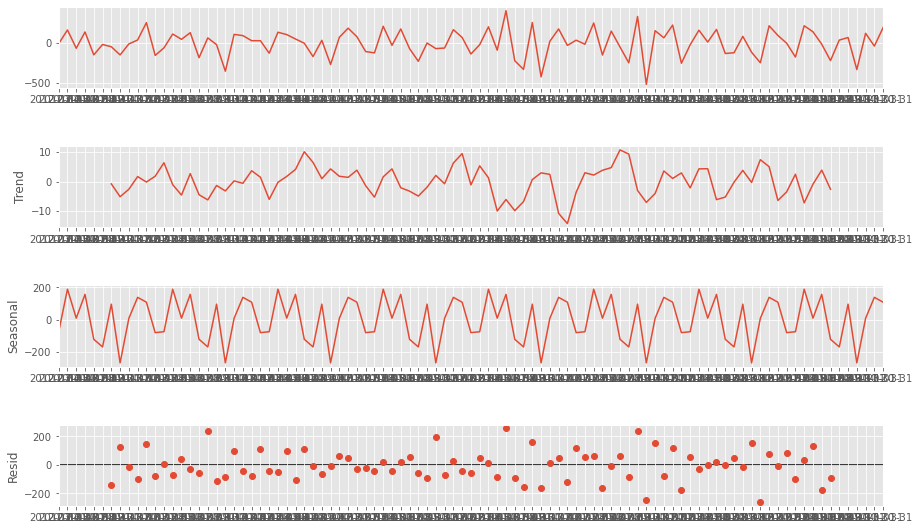

In [92]:
res = sm.tsa.seasonal_decompose(diffed,period=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.savefig('images/seas_decomp_diffed.png')

<h4>Split the data into training and testing sets</h4>

In [93]:
#train_test_split 
tr_start,tr_end = '2012-03-31','2018-05-31'
te_start,te_end = '2018-06-30','2020-01-31'
train = diffed[tr_start:tr_end]
test = diffed[te_start:te_end]

<h4>Scope the AR (p) and MA (q) terms with ACF plot</h4>

/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


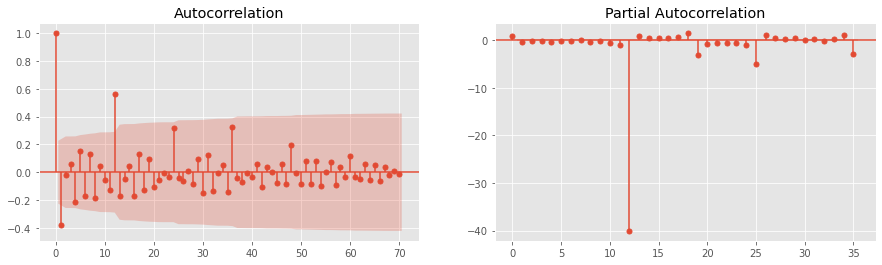

In [94]:
# SARIMAX AC and PAC 

fig, ax = plt.subplots(1, 2, figsize=(15,4))
fig = sm.graphics.tsa.plot_acf(train, lags=70, ax=ax[0])

fig = sm.graphics.tsa.plot_pacf(train, lags=35, ax=ax[1])
#plt.show()
plt.savefig('images/AC_PAC_functions.png')

<h4>Run gridsearch to find optimal parameters</h4>

In [7]:
# Find optimized parameters for SARIMAX not diffed

#set parameter range
p = range(0,3)
q = range(1,3)
d = range(1,2)
s = range(1,12)
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))
# SARIMA model pipeline
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                    order=param,
                                    seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 50, method = 'powell')

            print('SARIMAX{},{} - AIC:{}'.format(param, param_seasonal, results.aic)) 
        except:
            continue

/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.425929
         Iterations: 3
         Function evaluations: 176
SARIMAX(0, 1, 1),(0, 1, 1, 2) - AIC:969.8893249598236
Optimization terminated successfully.
         Current function value: 6.298882
         Iterations: 3
         Function evaluations: 114
SARIMAX(0, 1, 1),(0, 1, 1, 3) - AIC:950.8323650249329
Optimization terminated successfully.
         Current function value: 6.231086
         Iterations: 3
         Function evaluations: 184
SARIMAX(0, 1, 1),(0, 1, 1, 4) - AIC:940.6629316532093


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.189378
         Iterations: 3
         Function evaluations: 181
SARIMAX(0, 1, 1),(0, 1, 1, 5) - AIC:934.4066776727881
Optimization terminated successfully.
         Current function value: 6.027423
         Iterations: 3
         Function evaluations: 188
SARIMAX(0, 1, 1),(0, 1, 1, 6) - AIC:910.1134707736809
Optimization terminated successfully.
         Current function value: 6.024526
         Iterations: 3
         Function evaluations: 179
SARIMAX(0, 1, 1),(0, 1, 1, 7) - AIC:909.6788770806191


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no asso

Optimization terminated successfully.
         Current function value: 5.938356
         Iterations: 4
         Function evaluations: 217
SARIMAX(0, 1, 1),(0, 1, 1, 8) - AIC:896.7534204981317
Optimization terminated successfully.
         Current function value: 5.839408
         Iterations: 3
         Function evaluations: 179
SARIMAX(0, 1, 1),(0, 1, 1, 9) - AIC:881.9111462838221


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 5.815533
         Iterations: 3
         Function evaluations: 185
SARIMAX(0, 1, 1),(0, 1, 1, 10) - AIC:878.3299386836245
Optimization terminated successfully.
         Current function value: 5.718127
         Iterations: 4
         Function evaluations: 227
SARIMAX(0, 1, 1),(0, 1, 1, 11) - AIC:863.7191138762353


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.425758
         Iterations: 3
         Function evaluations: 214
SARIMAX(0, 1, 1),(0, 1, 2, 2) - AIC:971.8636612094047
Optimization terminated successfully.
         Current function value: 6.295891
         Iterations: 3
         Function evaluations: 156
SARIMAX(0, 1, 1),(0, 1, 2, 3) - AIC:952.3836919309003
Optimization terminated successfully.
         Current function value: 6.140980
         Iterations: 4
         Function evaluations: 262


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

SARIMAX(0, 1, 1),(0, 1, 2, 4) - AIC:929.1470214884744
Optimization terminated successfully.
         Current function value: 6.175244
         Iterations: 3
         Function evaluations: 221
SARIMAX(0, 1, 1),(0, 1, 2, 5) - AIC:934.2866457431745


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 5.954152
         Iterations: 3
         Function evaluations: 163
SARIMAX(0, 1, 1),(0, 1, 2, 6) - AIC:901.1228595313758
Optimization terminated successfully.
         Current function value: 6.019176
         Iterations: 3
         Function evaluations: 218
SARIMAX(0, 1, 1),(0, 1, 2, 7) - AIC:910.8764650739647


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.891914
         Iterations: 4
         Function evaluations: 275
SARIMAX(0, 1, 1),(0, 1, 2, 8) - AIC:891.7871696176112


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.838008
         Iterations: 3
         Function evaluations: 225
SARIMAX(0, 1, 1),(0, 1, 2, 9) - AIC:883.701201155511


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.813700
         Iterations: 4
         Function evaluations: 256
SARIMAX(0, 1, 1),(0, 1, 2, 10) - AIC:880.0549364452106


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


Optimization terminated successfully.
         Current function value: 5.708411
         Iterations: 3
         Function evaluations: 215
SARIMAX(0, 1, 1),(0, 1, 2, 11) - AIC:864.2616142797305
Optimization terminated successfully.
         Current function value: 6.425477
         Iterations: 4
         Function evaluations: 215
SARIMAX(0, 1, 1),(1, 1, 1, 2) - AIC:971.8215276911947


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.298226
         Iterations: 4
         Function evaluations: 252
SARIMAX(0, 1, 1),(1, 1, 1, 3) - AIC:952.7338990153164
Optimization terminated successfully.
         Current function value: 6.183326
         Iterations: 4
         Function evaluations: 269
SARIMAX(0, 1, 1),(1, 1, 1, 4) - AIC:935.4988472133396


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.180555
         Iterations: 4
         Function evaluations: 262
SARIMAX(0, 1, 1),(1, 1, 1, 5) - AIC:935.0832599357475
Optimization terminated successfully.
         Current function value: 5.785792
         Iterations: 4
         Function evaluations: 286
SARIMAX(0, 1, 1),(1, 1, 1, 6) - AIC:875.8687554888811


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.018585
         Iterations: 4
         Function evaluations: 265
SARIMAX(0, 1, 1),(1, 1, 1, 7) - AIC:910.7877045757537
Optimization terminated successfully.
         Current function value: 5.914455
         Iterations: 5
         Function evaluations: 317
SARIMAX(0, 1, 1),(1, 1, 1, 8) - AIC:895.1683002909458


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 5.838810
         Iterations: 4
         Function evaluations: 260
SARIMAX(0, 1, 1),(1, 1, 1, 9) - AIC:883.8215054741045


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.814235
         Iterations: 6
         Function evaluations: 353
SARIMAX(0, 1, 1),(1, 1, 1, 10) - AIC:880.1353218368777
Optimization terminated successfully.
         Current function value: 5.710816
         Iterations: 4
         Function evaluations: 208
SARIMAX(0, 1, 1),(1, 1, 1, 11) - AIC:864.6224628108483


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.423526
         Iterations: 3
         Function evaluations: 197
SARIMAX(0, 1, 1),(1, 1, 2, 2) - AIC:973.5289109132706
Optimization terminated successfully.
         Current function value: 6.298137
         Iterations: 3
         Function evaluations: 198
SARIMAX(0, 1, 1),(1, 1, 2, 3) - AIC:954.7205158752743


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.141511
         Iterations: 5
         Function evaluations: 383
SARIMAX(0, 1, 1),(1, 1, 2, 4) - AIC:931.2266062286233
Optimization terminated successfully.
         Current function value: 6.155359
         Iterations: 4
         Function evaluations: 329
SARIMAX(0, 1, 1),(1, 1, 2, 5) - AIC:933.3038476119723


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 5.772742
         Iterations: 4
         Function evaluations: 307
SARIMAX(0, 1, 1),(1, 1, 2, 6) - AIC:875.9112385319071


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.020897
         Iterations: 4
         Function evaluations: 317
SARIMAX(0, 1, 1),(1, 1, 2, 7) - AIC:913.1344795155582


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.885051
         Iterations: 5
         Function evaluations: 400
SARIMAX(0, 1, 1),(1, 1, 2, 8) - AIC:892.7576327984794


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.837373
         Iterations: 4
         Function evaluations: 313
SARIMAX(0, 1, 1),(1, 1, 2, 9) - AIC:885.605946748644


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.815276
         Iterations: 4
         Function evaluations: 317
SARIMAX(0, 1, 1),(1, 1, 2, 10) - AIC:882.2913283819108


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.711701
         Iterations: 4
         Function evaluations: 325
SARIMAX(0, 1, 1),(1, 1, 2, 11) - AIC:866.7551629488424
Optimization terminated successfully.
         Current function value: 6.409168
         Iterations: 4
         Function evaluations: 316
SARIMAX(0, 1, 1),(2, 1, 1, 2) - AIC:971.3751429485637


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.229495
         Iterations: 4
         Function evaluations: 274
SARIMAX(0, 1, 1),(2, 1, 1, 3) - AIC:944.424306726308
Optimization terminated successfully.
         Current function value: 5.935593
         Iterations: 4
         Function evaluations: 273
SARIMAX(0, 1, 1),(2, 1, 1, 4) - AIC:900.3389691148286


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.197094
         Iterations: 3
         Function evaluations: 191
SARIMAX(0, 1, 1),(2, 1, 1, 5) - AIC:939.5640512876822
Optimization terminated successfully.
         Current function value: 5.788080
         Iterations: 3
         Function evaluations: 215
SARIMAX(0, 1, 1),(2, 1, 1, 6) - AIC:878.2119558071014


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.031273
         Iterations: 3
         Function evaluations: 190
SARIMAX(0, 1, 1),(2, 1, 1, 7) - AIC:914.6910006062973


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Optimization terminated successfully.
         Current function value: 5.822888
         Iterations: 4
         Function evaluations: 309
SARIMAX(0, 1, 1),(2, 1, 1, 8) - AIC:883.4331374751889


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.814293
         Iterations: 5
         Function evaluations: 368
SARIMAX(0, 1, 1),(2, 1, 1, 9) - AIC:882.144009083464


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.813697
         Iterations: 7
         Function evaluations: 498
SARIMAX(0, 1, 1),(2, 1, 1, 10) - AIC:882.0545683200837


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.751452
         Iterations: 4
         Function evaluations: 257
SARIMAX(0, 1, 1),(2, 1, 1, 11) - AIC:872.7178473059831
Optimization terminated successfully.
         Current function value: 6.416977
         Iterations: 4
         Function evaluations: 355
SARIMAX(0, 1, 1),(2, 1, 2, 2) - AIC:974.5465553167951


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.187398
         Iterations: 8
         Function evaluations: 653
SARIMAX(0, 1, 1),(2, 1, 2, 3) - AIC:940.1096718936963


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.933559
         Iterations: 5
         Function evaluations: 438
SARIMAX(0, 1, 1),(2, 1, 2, 4) - AIC:902.0338009872557


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.155219
         Iterations: 6
         Function evaluations: 512
SARIMAX(0, 1, 1),(2, 1, 2, 5) - AIC:935.2828434492022


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.756291
         Iterations: 4
         Function evaluations: 339
SARIMAX(0, 1, 1),(2, 1, 2, 6) - AIC:875.4436352689213


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.018126
         Iterations: 6
         Function evaluations: 499
SARIMAX(0, 1, 1),(2, 1, 2, 7) - AIC:914.7189078832746


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.790484
         Iterations: 6
         Function evaluations: 504
SARIMAX(0, 1, 1),(2, 1, 2, 8) - AIC:880.5725842470902


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.766619
         Iterations: 8
         Function evaluations: 663
SARIMAX(0, 1, 1),(2, 1, 2, 9) - AIC:876.9928935469251


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.801112
         Iterations: 9
         Function evaluations: 722
SARIMAX(0, 1, 1),(2, 1, 2, 10) - AIC:882.1668028438457


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.709256
         Iterations: 4
         Function evaluations: 355
SARIMAX(0, 1, 1),(2, 1, 2, 11) - AIC:868.3883287928348
Optimization terminated successfully.
         Current function value: 6.222061
         Iterations: 4
         Function evaluations: 209
SARIMAX(0, 1, 2),(0, 1, 1, 3) - AIC:941.3091619570438


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.135012
         Iterations: 4
         Function evaluations: 272
SARIMAX(0, 1, 2),(0, 1, 1, 4) - AIC:928.2517935045929
Optimization terminated successfully.
         Current function value: 6.086743
         Iterations: 5
         Function evaluations: 288
SARIMAX(0, 1, 2),(0, 1, 1, 5) - AIC:921.0114086076694


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 5.990525
         Iterations: 4
         Function evaluations: 197
SARIMAX(0, 1, 2),(0, 1, 1, 6) - AIC:906.5786987746296


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.937709
         Iterations: 7
         Function evaluations: 459
SARIMAX(0, 1, 2),(0, 1, 1, 7) - AIC:898.6562952979665
Optimization terminated successfully.
         Current function value: 5.831024
         Iterations: 5
         Function evaluations: 299
SARIMAX(0, 1, 2),(0, 1, 1, 8) - AIC:882.6536155042321


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 5.773545
         Iterations: 4
         Function evaluations: 259
SARIMAX(0, 1, 2),(0, 1, 1, 9) - AIC:874.0317599371191
Optimization terminated successfully.
         Current function value: 5.701293
         Iterations: 5
         Function evaluations: 267
SARIMAX(0, 1, 2),(0, 1, 1, 10) - AIC:863.1940188861654


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 5.524858
         Iterations: 4
         Function evaluations: 207
SARIMAX(0, 1, 2),(0, 1, 1, 11) - AIC:836.7287556092358
Optimization terminated successfully.
         Current function value: 6.195279
         Iterations: 4
         Function evaluations: 270
SARIMAX(0, 1, 2),(0, 1, 2, 3) - AIC:939.2919098617467


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 5.993207
         Iterations: 5
         Function evaluations: 351
SARIMAX(0, 1, 2),(0, 1, 2, 4) - AIC:908.9810070486767
Optimization terminated successfully.
         Current function value: 6.085098
         Iterations: 4
         Function evaluations: 309
SARIMAX(0, 1, 2),(0, 1, 2, 5) - AIC:922.7646941452695


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 5.800843
         Iterations: 12
         Function evaluations: 754
SARIMAX(0, 1, 2),(0, 1, 2, 6) - AIC:880.1264555014068


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.931456
         Iterations: 6
         Function evaluations: 436
SARIMAX(0, 1, 2),(0, 1, 2, 7) - AIC:899.7184641850966


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.737128
         Iterations: 5
         Function evaluations: 297
SARIMAX(0, 1, 2),(0, 1, 2, 8) - AIC:870.5692124124944


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.772105
         Iterations: 4
         Function evaluations: 317
SARIMAX(0, 1, 2),(0, 1, 2, 9) - AIC:875.8157933986838


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.677208
         Iterations: 4
         Function evaluations: 292
SARIMAX(0, 1, 2),(0, 1, 2, 10) - AIC:861.5812697855818


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.520022
         Iterations: 4
         Function evaluations: 263
SARIMAX(0, 1, 2),(0, 1, 2, 11) - AIC:838.0032290267679
Optimization terminated successfully.
         Current function value: 6.215639
         Iterations: 4
         Function evaluations: 250
SARIMAX(0, 1, 2),(1, 1, 1, 3) - AIC:942.3458584182815


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.071684
         Iterations: 4
         Function evaluations: 272
SARIMAX(0, 1, 2),(1, 1, 1, 4) - AIC:920.7525821286771
Optimization terminated successfully.
         Current function value: 6.075501
         Iterations: 5
         Function evaluations: 362
SARIMAX(0, 1, 2),(1, 1, 1, 5) - AIC:921.3251159207988


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 5.533720
         Iterations: 5
         Function evaluations: 325
SARIMAX(0, 1, 2),(1, 1, 1, 6) - AIC:840.0580381175056
Optimization terminated successfully.
         Current function value: 5.926784
         Iterations: 5
         Function evaluations: 310
SARIMAX(0, 1, 2),(1, 1, 1, 7) - AIC:899.0176086338706


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 5.793631
         Iterations: 4
         Function evaluations: 308
SARIMAX(0, 1, 2),(1, 1, 1, 8) - AIC:879.0445953104235


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.772279
         Iterations: 5
         Function evaluations: 374
SARIMAX(0, 1, 2),(1, 1, 1, 9) - AIC:875.8418471257614


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.685118
         Iterations: 6
         Function evaluations: 393
SARIMAX(0, 1, 2),(1, 1, 1, 10) - AIC:862.767752786769


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.519542
         Iterations: 8
         Function evaluations: 556
SARIMAX(0, 1, 2),(1, 1, 1, 11) - AIC:837.9313196154237
Optimization terminated successfully.
         Current function value: 6.220028
         Iterations: 4
         Function evaluations: 313
SARIMAX(0, 1, 2),(1, 1, 2, 3) - AIC:945.0042716030697


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 5.992852
         Iterations: 6
         Function evaluations: 473
SARIMAX(0, 1, 2),(1, 1, 2, 4) - AIC:910.9278312122066


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.092136
         Iterations: 6
         Function evaluations: 506
SARIMAX(0, 1, 2),(1, 1, 2, 5) - AIC:925.8204175616563


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.471351
         Iterations: 5
         Function evaluations: 390
SARIMAX(0, 1, 2),(1, 1, 2, 6) - AIC:832.7026273809294


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.926503
         Iterations: 8
         Function evaluations: 661
SARIMAX(0, 1, 2),(1, 1, 2, 7) - AIC:900.9754124441631


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.736904
         Iterations: 6
         Function evaluations: 485
SARIMAX(0, 1, 2),(1, 1, 2, 8) - AIC:872.5355444198929


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.772606
         Iterations: 5
         Function evaluations: 431
SARIMAX(0, 1, 2),(1, 1, 2, 9) - AIC:877.8908488298528


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.693850
         Iterations: 4
         Function evaluations: 411
SARIMAX(0, 1, 2),(1, 1, 2, 10) - AIC:866.0774439787293


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.521231
         Iterations: 4
         Function evaluations: 314
SARIMAX(0, 1, 2),(1, 1, 2, 11) - AIC:840.1845762293816
Optimization terminated successfully.
         Current function value: 6.117709
         Iterations: 4
         Function evaluations: 286
SARIMAX(0, 1, 2),(2, 1, 1, 3) - AIC:929.6563613905528


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 5.686837
         Iterations: 5
         Function evaluations: 384
SARIMAX(0, 1, 2),(2, 1, 1, 4) - AIC:865.025545438519


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.070160
         Iterations: 10
         Function evaluations: 867
SARIMAX(0, 1, 2),(2, 1, 1, 5) - AIC:922.524047345328


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.512110
         Iterations: 11
         Function evaluations: 874
SARIMAX(0, 1, 2),(2, 1, 1, 6) - AIC:838.8165158759347


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.916472
         Iterations: 8
         Function evaluations: 650
SARIMAX(0, 1, 2),(2, 1, 1, 7) - AIC:899.4708138361269


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.562315
         Iterations: 6
         Function evaluations: 489
SARIMAX(0, 1, 2),(2, 1, 1, 8) - AIC:846.3472921466009


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.710741
         Iterations: 5
         Function evaluations: 417
SARIMAX(0, 1, 2),(2, 1, 1, 9) - AIC:868.6111487002596


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.676960
         Iterations: 7
         Function evaluations: 530
SARIMAX(0, 1, 2),(2, 1, 1, 10) - AIC:863.5440509411928


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.537495
         Iterations: 4
         Function evaluations: 298
SARIMAX(0, 1, 2),(2, 1, 1, 11) - AIC:842.6242502615547


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.026083
         Iterations: 8
         Function evaluations: 722
SARIMAX(0, 1, 2),(2, 1, 2, 3) - AIC:917.9123820181757


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.686351
         Iterations: 5
         Function evaluations: 434
SARIMAX(0, 1, 2),(2, 1, 2, 4) - AIC:866.9526294959276


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.056596
         Iterations: 7
         Function evaluations: 680
SARIMAX(0, 1, 2),(2, 1, 2, 5) - AIC:922.4893726298867


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.921869
         Iterations: 7
         Function evaluations: 659
SARIMAX(0, 1, 2),(2, 1, 2, 6) - AIC:902.2803017044622


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.917636
         Iterations: 8
         Function evaluations: 687
SARIMAX(0, 1, 2),(2, 1, 2, 7) - AIC:901.6454547154349


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.554485
         Iterations: 6
         Function evaluations: 562
SARIMAX(0, 1, 2),(2, 1, 2, 8) - AIC:847.1728115439214


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.635244
         Iterations: 17
         Function evaluations: 1574
SARIMAX(0, 1, 2),(2, 1, 2, 9) - AIC:859.2865530378346


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.678755
         Iterations: 6
         Function evaluations: 577
SARIMAX(0, 1, 2),(2, 1, 2, 10) - AIC:865.8131796864277


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.519493
         Iterations: 6
         Function evaluations: 546
SARIMAX(0, 1, 2),(2, 1, 2, 11) - AIC:841.9239804799143
Optimization terminated successfully.
         Current function value: 6.353862
         Iterations: 3
         Function evaluations: 212
SARIMAX(1, 1, 1),(0, 1, 1, 2) - AIC:961.0793577657262


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.236091
         Iterations: 4
         Function evaluations: 255
SARIMAX(1, 1, 1),(0, 1, 1, 3) - AIC:943.4137187867777
Optimization terminated successfully.
         Current function value: 6.141046
         Iterations: 4
         Function evaluations: 281
SARIMAX(1, 1, 1),(0, 1, 1, 4) - AIC:929.1568321529013


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.133431
         Iterations: 4
         Function evaluations: 257
SARIMAX(1, 1, 1),(0, 1, 1, 5) - AIC:928.0146331483577
Optimization terminated successfully.
         Current function value: 5.916125
         Iterations: 4
         Function evaluations: 268
SARIMAX(1, 1, 1),(0, 1, 1, 6) - AIC:895.4188068957473


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 5.979625
         Iterations: 4
         Function evaluations: 274
SARIMAX(1, 1, 1),(0, 1, 1, 7) - AIC:904.9437136590092
Optimization terminated successfully.
         Current function value: 5.853796
         Iterations: 4
         Function evaluations: 277
SARIMAX(1, 1, 1),(0, 1, 1, 8) - AIC:886.0693916318669


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 5.787311
         Iterations: 4
         Function evaluations: 271
SARIMAX(1, 1, 1),(0, 1, 1, 9) - AIC:876.0965951052225
Optimization terminated successfully.
         Current function value: 5.752945
         Iterations: 4
         Function evaluations: 275
SARIMAX(1, 1, 1),(0, 1, 1, 10) - AIC:870.941699767832


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 5.638665
         Iterations: 4
         Function evaluations: 221
SARIMAX(1, 1, 1),(0, 1, 1, 11) - AIC:853.7997420636246
Optimization terminated successfully.
         Current function value: 6.290073
         Iterations: 6
         Function evaluations: 438


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

SARIMAX(1, 1, 1),(0, 1, 2, 2) - AIC:953.5109697137585
Optimization terminated successfully.
         Current function value: 6.215092
         Iterations: 3
         Function evaluations: 201
SARIMAX(1, 1, 1),(0, 1, 2, 3) - AIC:942.2638329026408


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.022395
         Iterations: 4
         Function evaluations: 328
SARIMAX(1, 1, 1),(0, 1, 2, 4) - AIC:913.3592553578834
Optimization terminated successfully.
         Current function value: 6.128741
         Iterations: 3
         Function evaluations: 259
SARIMAX(1, 1, 1),(0, 1, 2, 5) - AIC:929.3112163204204


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 5.837038
         Iterations: 3
         Function evaluations: 206
SARIMAX(1, 1, 1),(0, 1, 2, 6) - AIC:885.5557146739341
Optimization terminated successfully.
         Current function value: 5.975090
         Iterations: 4
         Function evaluations: 315
SARIMAX(1, 1, 1),(0, 1, 2, 7) - AIC:906.2634993619433


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.784588
         Iterations: 5
         Function evaluations: 383
SARIMAX(1, 1, 1),(0, 1, 2, 8) - AIC:877.6882625279128


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.785511
         Iterations: 4
         Function evaluations: 315
SARIMAX(1, 1, 1),(0, 1, 2, 9) - AIC:877.8266422637457


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.752897
         Iterations: 4
         Function evaluations: 305
SARIMAX(1, 1, 1),(0, 1, 2, 10) - AIC:872.9345396521982


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.636812
         Iterations: 3
         Function evaluations: 263
SARIMAX(1, 1, 1),(0, 1, 2, 11) - AIC:855.5218040713012
Optimization terminated successfully.
         Current function value: 6.342019
         Iterations: 4
         Function evaluations: 277
SARIMAX(1, 1, 1),(1, 1, 1, 2) - AIC:961.302835036088


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.229677
         Iterations: 4
         Function evaluations: 261
SARIMAX(1, 1, 1),(1, 1, 1, 3) - AIC:944.451502402259
Optimization terminated successfully.
         Current function value: 6.083298
         Iterations: 4
         Function evaluations: 330
SARIMAX(1, 1, 1),(1, 1, 1, 4) - AIC:922.4947062955963


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.130968
         Iterations: 4
         Function evaluations: 309
SARIMAX(1, 1, 1),(1, 1, 1, 5) - AIC:929.6452555797363
Optimization terminated successfully.
         Current function value: 5.637304
         Iterations: 4
         Function evaluations: 327
SARIMAX(1, 1, 1),(1, 1, 1, 6) - AIC:855.5955873148521


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 5.974938
         Iterations: 4
         Function evaluations: 315
SARIMAX(1, 1, 1),(1, 1, 1, 7) - AIC:906.2406883434792


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.821866
         Iterations: 4
         Function evaluations: 333
SARIMAX(1, 1, 1),(1, 1, 1, 8) - AIC:883.2798398088116


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.786535
         Iterations: 5
         Function evaluations: 389
SARIMAX(1, 1, 1),(1, 1, 1, 9) - AIC:877.980321614271


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.752887
         Iterations: 6
         Function evaluations: 437
SARIMAX(1, 1, 1),(1, 1, 1, 10) - AIC:872.9331148784397


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.637135
         Iterations: 8
         Function evaluations: 571
SARIMAX(1, 1, 1),(1, 1, 1, 11) - AIC:855.5701825037808
Optimization terminated successfully.
         Current function value: 6.349956
         Iterations: 4
         Function evaluations: 372
SARIMAX(1, 1, 1),(1, 1, 2, 2) - AIC:964.4934691235611


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.232889
         Iterations: 3
         Function evaluations: 239
SARIMAX(1, 1, 1),(1, 1, 2, 3) - AIC:946.9333332643878


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.021720
         Iterations: 5
         Function evaluations: 438
SARIMAX(1, 1, 1),(1, 1, 2, 4) - AIC:915.2579935254842


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.108246
         Iterations: 6
         Function evaluations: 517
SARIMAX(1, 1, 1),(1, 1, 2, 5) - AIC:928.2369076162926


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.583516
         Iterations: 4
         Function evaluations: 336
SARIMAX(1, 1, 1),(1, 1, 2, 6) - AIC:849.5274140531561


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.975231
         Iterations: 5
         Function evaluations: 439
SARIMAX(1, 1, 1),(1, 1, 2, 7) - AIC:908.2846934412484


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.780533
         Iterations: 6
         Function evaluations: 523
SARIMAX(1, 1, 1),(1, 1, 2, 8) - AIC:879.0799900447645


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.784900
         Iterations: 5
         Function evaluations: 427
SARIMAX(1, 1, 1),(1, 1, 2, 9) - AIC:879.7350492438557


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.751855
         Iterations: 5
         Function evaluations: 441
SARIMAX(1, 1, 1),(1, 1, 2, 10) - AIC:874.7782782807817


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.637134
         Iterations: 4
         Function evaluations: 314
SARIMAX(1, 1, 1),(1, 1, 2, 11) - AIC:857.5700372261193


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.322107
         Iterations: 5
         Function evaluations: 446
SARIMAX(1, 1, 1),(2, 1, 1, 2) - AIC:960.3159768561387
Optimization terminated successfully.
         Current function value: 6.190951
         Iterations: 4
         Function evaluations: 321
SARIMAX(1, 1, 1),(2, 1, 1, 3) - AIC:940.6426053496322


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 5.780566
         Iterations: 4
         Function evaluations: 318
SARIMAX(1, 1, 1),(2, 1, 1, 4) - AIC:879.0849663931864
Optimization terminated successfully.
         Current function value: 6.176069
         Iterations: 3
         Function evaluations: 232
SARIMAX(1, 1, 1),(2, 1, 1, 5) - AIC:938.4103703016128


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 5.640352
         Iterations: 4
         Function evaluations: 323
SARIMAX(1, 1, 1),(2, 1, 1, 6) - AIC:858.0527748291199


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.975075
         Iterations: 7
         Function evaluations: 567
SARIMAX(1, 1, 1),(2, 1, 1, 7) - AIC:908.2612052279853


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.667665
         Iterations: 4
         Function evaluations: 351
SARIMAX(1, 1, 1),(2, 1, 1, 8) - AIC:862.1498103032541


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.774579
         Iterations: 5
         Function evaluations: 436
SARIMAX(1, 1, 1),(2, 1, 1, 9) - AIC:878.1868803924519


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.754565
         Iterations: 6
         Function evaluations: 505
SARIMAX(1, 1, 1),(2, 1, 1, 10) - AIC:875.184712763177


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.672729
         Iterations: 4
         Function evaluations: 296
SARIMAX(1, 1, 1),(2, 1, 1, 11) - AIC:862.9093008063095


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.256512
         Iterations: 11
         Function evaluations: 1056
SARIMAX(1, 1, 1),(2, 1, 2, 2) - AIC:952.4768250327961


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.135292
         Iterations: 12
         Function evaluations: 1091
SARIMAX(1, 1, 1),(2, 1, 2, 3) - AIC:934.2938366713262


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.780051
         Iterations: 5
         Function evaluations: 456
SARIMAX(1, 1, 1),(2, 1, 2, 4) - AIC:881.00763343408


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.107964
         Iterations: 6
         Function evaluations: 586
SARIMAX(1, 1, 1),(2, 1, 2, 5) - AIC:930.1945527213833


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.579688
         Iterations: 4
         Function evaluations: 404
SARIMAX(1, 1, 1),(2, 1, 2, 6) - AIC:850.9532527485534


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.974042
         Iterations: 6
         Function evaluations: 580
SARIMAX(1, 1, 1),(2, 1, 2, 7) - AIC:910.1063402276228


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.649762
         Iterations: 6
         Function evaluations: 582
SARIMAX(1, 1, 1),(2, 1, 2, 8) - AIC:861.4643746630956


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.720612
         Iterations: 13
         Function evaluations: 1174
SARIMAX(1, 1, 1),(2, 1, 2, 9) - AIC:872.091777254446


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.751272
         Iterations: 6
         Function evaluations: 588
SARIMAX(1, 1, 1),(2, 1, 2, 10) - AIC:876.6907880334222


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.637047
         Iterations: 5
         Function evaluations: 486
SARIMAX(1, 1, 1),(2, 1, 2, 11) - AIC:859.5570733603181


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.168381
         Iterations: 8
         Function evaluations: 501
SARIMAX(1, 1, 2),(0, 1, 1, 3) - AIC:935.2571438261306
Optimization terminated successfully.
         Current function value: 6.136381
         Iterations: 5
         Function evaluations: 384
SARIMAX(1, 1, 2),(0, 1, 1, 4) - AIC:930.45714882888


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.057886
         Iterations: 8
         Function evaluations: 571
SARIMAX(1, 1, 2),(0, 1, 1, 5) - AIC:918.6829000152251
Optimization terminated successfully.
         Current function value: 5.908800
         Iterations: 5
         Function evaluations: 392


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, b

SARIMAX(1, 1, 2),(0, 1, 1, 6) - AIC:896.3200298044227
Optimization terminated successfully.
         Current function value: 5.900134
         Iterations: 8
         Function evaluations: 570
SARIMAX(1, 1, 2),(0, 1, 1, 7) - AIC:895.0200625469691
Optimization terminated successfully.
         Current function value: 5.847018
         Iterations: 5
         Function evaluations: 365


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(1, 1, 2),(0, 1, 1, 8) - AIC:887.0526772975277
Optimization terminated successfully.
         Current function value: 5.826819
         Iterations: 4
         Function evaluations: 262
SARIMAX(1, 1, 2),(0, 1, 1, 9) - AIC:884.0228682306015


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.676659
         Iterations: 7
         Function evaluations: 490
SARIMAX(1, 1, 2),(0, 1, 1, 10) - AIC:861.4989116215871


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.522708
         Iterations: 11
         Function evaluations: 673
SARIMAX(1, 1, 2),(0, 1, 1, 11) - AIC:838.4062049797657


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.162842
         Iterations: 9
         Function evaluations: 723
SARIMAX(1, 1, 2),(0, 1, 2, 3) - AIC:936.4263071714574


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.979234
         Iterations: 9
         Function evaluations: 751
SARIMAX(1, 1, 2),(0, 1, 2, 4) - AIC:908.885082378338


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.057545
         Iterations: 8
         Function evaluations: 647
SARIMAX(1, 1, 2),(0, 1, 2, 5) - AIC:920.6317937821736


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.816178
         Iterations: 6
         Function evaluations: 533
SARIMAX(1, 1, 2),(0, 1, 2, 6) - AIC:884.4267243346142


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.899897
         Iterations: 10
         Function evaluations: 770
SARIMAX(1, 1, 2),(0, 1, 2, 7) - AIC:896.9845839401825


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.729047
         Iterations: 11
         Function evaluations: 941
SARIMAX(1, 1, 2),(0, 1, 2, 8) - AIC:871.3570600203537


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.825013
         Iterations: 3
         Function evaluations: 245
SARIMAX(1, 1, 2),(0, 1, 2, 9) - AIC:885.75189433096


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.665246
         Iterations: 6
         Function evaluations: 623
SARIMAX(1, 1, 2),(0, 1, 2, 10) - AIC:861.7868869335231


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.519518
         Iterations: 6
         Function evaluations: 452
SARIMAX(1, 1, 2),(0, 1, 2, 11) - AIC:839.927773476294


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.169887
         Iterations: 10
         Function evaluations: 846
SARIMAX(1, 1, 2),(1, 1, 1, 3) - AIC:937.483060696261


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.037182
         Iterations: 9
         Function evaluations: 747
SARIMAX(1, 1, 2),(1, 1, 1, 4) - AIC:917.577333030633


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.056127
         Iterations: 6
         Function evaluations: 507
SARIMAX(1, 1, 2),(1, 1, 1, 5) - AIC:920.4190816369137


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.534545
         Iterations: 9
         Function evaluations: 653
SARIMAX(1, 1, 2),(1, 1, 1, 6) - AIC:842.181679282014


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.899791
         Iterations: 12
         Function evaluations: 991
SARIMAX(1, 1, 2),(1, 1, 1, 7) - AIC:896.9686643692197


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.768904
         Iterations: 8
         Function evaluations: 654
SARIMAX(1, 1, 2),(1, 1, 1, 8) - AIC:877.3355815899074


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.825703
         Iterations: 4
         Function evaluations: 366
SARIMAX(1, 1, 2),(1, 1, 1, 9) - AIC:885.8554716203412


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.665996
         Iterations: 7
         Function evaluations: 632
SARIMAX(1, 1, 2),(1, 1, 1, 10) - AIC:861.8994193576068


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.525184
         Iterations: 10
         Function evaluations: 794
SARIMAX(1, 1, 2),(1, 1, 1, 11) - AIC:840.7775616932562


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.146125
         Iterations: 18
         Function evaluations: 1565
SARIMAX(1, 1, 2),(1, 1, 2, 3) - AIC:935.9186848603146


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.986108
         Iterations: 12
         Function evaluations: 1121
SARIMAX(1, 1, 2),(1, 1, 2, 4) - AIC:911.916251869216


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.040017
         Iterations: 8
         Function evaluations: 836
SARIMAX(1, 1, 2),(1, 1, 2, 5) - AIC:920.0025379786066


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.467394
         Iterations: 9
         Function evaluations: 740
SARIMAX(1, 1, 2),(1, 1, 2, 6) - AIC:834.109155456071


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.899248
         Iterations: 7
         Function evaluations: 683
SARIMAX(1, 1, 2),(1, 1, 2, 7) - AIC:898.8871652998689


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.724884
         Iterations: 10
         Function evaluations: 942
SARIMAX(1, 1, 2),(1, 1, 2, 8) - AIC:872.7325491825216


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.824865
         Iterations: 4
         Function evaluations: 361
SARIMAX(1, 1, 2),(1, 1, 2, 9) - AIC:887.729760067685


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.672540
         Iterations: 6
         Function evaluations: 622
SARIMAX(1, 1, 2),(1, 1, 2, 10) - AIC:864.8810161569887


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.520627
         Iterations: 4
         Function evaluations: 351
SARIMAX(1, 1, 2),(1, 1, 2, 11) - AIC:842.0940750686548


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.089420
         Iterations: 8
         Function evaluations: 753
SARIMAX(1, 1, 2),(2, 1, 1, 3) - AIC:927.4130675604902


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.687557
         Iterations: 9
         Function evaluations: 799
SARIMAX(1, 1, 2),(2, 1, 1, 4) - AIC:867.1335312455998


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.054693
         Iterations: 11
         Function evaluations: 1049
SARIMAX(1, 1, 2),(2, 1, 1, 5) - AIC:922.2039746546081


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.510640
         Iterations: 9
         Function evaluations: 759
SARIMAX(1, 1, 2),(2, 1, 1, 6) - AIC:840.5960733162301


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.896883
         Iterations: 5
         Function evaluations: 557
SARIMAX(1, 1, 2),(2, 1, 1, 7) - AIC:898.5323778705449


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.560594
         Iterations: 6
         Function evaluations: 578
SARIMAX(1, 1, 2),(2, 1, 1, 8) - AIC:848.0890590342487


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.802975
         Iterations: 5
         Function evaluations: 505
SARIMAX(1, 1, 2),(2, 1, 1, 9) - AIC:884.4461935380644


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.664371
         Iterations: 10
         Function evaluations: 888
SARIMAX(1, 1, 2),(2, 1, 1, 10) - AIC:863.655603181337


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.537340
         Iterations: 6
         Function evaluations: 563
SARIMAX(1, 1, 2),(2, 1, 1, 11) - AIC:844.6009619750785


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.015249
         Iterations: 13
         Function evaluations: 1364
SARIMAX(1, 1, 2),(2, 1, 2, 3) - AIC:918.2874140702127


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.687853
         Iterations: 9
         Function evaluations: 872
SARIMAX(1, 1, 2),(2, 1, 2, 4) - AIC:869.1778895869434


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.038989
         Iterations: 14
         Function evaluations: 1433
SARIMAX(1, 1, 2),(2, 1, 2, 5) - AIC:921.8482857497238


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.466295
         Iterations: 8
         Function evaluations: 816
SARIMAX(1, 1, 2),(2, 1, 2, 6) - AIC:835.9443045625828


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.897515
         Iterations: 8
         Function evaluations: 776
SARIMAX(1, 1, 2),(2, 1, 2, 7) - AIC:900.6272420044818


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.555441
         Iterations: 10
         Function evaluations: 1044
SARIMAX(1, 1, 2),(2, 1, 2, 8) - AIC:849.3161772582421


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.758461
         Iterations: 8
         Function evaluations: 865
SARIMAX(1, 1, 2),(2, 1, 2, 9) - AIC:879.7692025419208


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.649750
         Iterations: 15
         Function evaluations: 1492
SARIMAX(1, 1, 2),(2, 1, 2, 10) - AIC:863.4624352410049


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.519365
         Iterations: 6
         Function evaluations: 582
SARIMAX(1, 1, 2),(2, 1, 2, 11) - AIC:843.9048135989026
Optimization terminated successfully.
         Current function value: 6.340140
         Iterations: 4
         Function evaluations: 277
SARIMAX(2, 1, 1),(0, 1, 1, 2) - AIC:961.0209620371274


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.230844
         Iterations: 4
         Function evaluations: 253
SARIMAX(2, 1, 1),(0, 1, 1, 3) - AIC:944.6266508634872
Optimization terminated successfully.
         Current function value: 6.136189
         Iterations: 7
         Function evaluations: 480


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(2, 1, 1),(0, 1, 1, 4) - AIC:930.4283047719667
Optimization terminated successfully.
         Current function value: 6.117954
         Iterations: 4
         Function evaluations: 309
SARIMAX(2, 1, 1),(0, 1, 1, 5) - AIC:927.6930706944104


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.906398
         Iterations: 5
         Function evaluations: 384
SARIMAX(2, 1, 1),(0, 1, 1, 6) - AIC:895.9596931468973
Optimization terminated successfully.
         Current function value: 5.961857
         Iterations: 5
         Function evaluations: 314
SARIMAX(2, 1, 1),(0, 1, 1, 7) - AIC:904.278576830145


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 5.951093
         Iterations: 3
         Function evaluations: 195
SARIMAX(2, 1, 1),(0, 1, 1, 8) - AIC:902.6639397300413
Optimization terminated successfully.
         Current function value: 5.782630
         Iterations: 4
         Function evaluations: 313


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

SARIMAX(2, 1, 1),(0, 1, 1, 9) - AIC:877.3945074481757
Optimization terminated successfully.
         Current function value: 5.739121
         Iterations: 4
         Function evaluations: 327
SARIMAX(2, 1, 1),(0, 1, 1, 10) - AIC:870.8681322443911
Optimization terminated successfully.
         Current function value: 5.604909
         Iterations: 4
         Function evaluations: 259
SARIMAX(2, 1, 1),(0, 1, 1, 11) - AIC:850.7363209121002


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.276246
         Iterations: 11
         Function evaluations: 951
SARIMAX(2, 1, 1),(0, 1, 2, 2) - AIC:953.4369309659595
Optimization terminated successfully.
         Current function value: 6.181822
         Iterations: 5
         Function evaluations: 379
SARIMAX(2, 1, 1),(0, 1, 2, 3) - AIC:939.2733560154458


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.017740
         Iterations: 10
         Function evaluations: 818
SARIMAX(2, 1, 1),(0, 1, 2, 4) - AIC:914.6609438649338


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.114801
         Iterations: 6
         Function evaluations: 458
SARIMAX(2, 1, 1),(0, 1, 2, 5) - AIC:929.2202079346808
Optimization terminated successfully.
         Current function value: 5.814518
         Iterations: 4
         Function evaluations: 304
SARIMAX(2, 1, 1),(0, 1, 2, 6) - AIC:884.1776885942279


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 5.958480
         Iterations: 10
         Function evaluations: 709
SARIMAX(2, 1, 1),(0, 1, 2, 7) - AIC:905.7720265821011


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.855548
         Iterations: 5
         Function evaluations: 379
SARIMAX(2, 1, 1),(0, 1, 2, 8) - AIC:890.332254322225


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.779281
         Iterations: 4
         Function evaluations: 305
SARIMAX(2, 1, 1),(0, 1, 2, 9) - AIC:878.8921327687157


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.735183
         Iterations: 4
         Function evaluations: 371
SARIMAX(2, 1, 1),(0, 1, 2, 10) - AIC:872.2774284097069


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.596421
         Iterations: 4
         Function evaluations: 368
SARIMAX(2, 1, 1),(0, 1, 2, 11) - AIC:851.4631037798017


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.220254
         Iterations: 6
         Function evaluations: 442
SARIMAX(2, 1, 1),(1, 1, 1, 3) - AIC:945.0381076437419


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.079141
         Iterations: 11
         Function evaluations: 800
SARIMAX(2, 1, 1),(1, 1, 1, 4) - AIC:923.8711627865523


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.116843
         Iterations: 5
         Function evaluations: 442
SARIMAX(2, 1, 1),(1, 1, 1, 5) - AIC:929.5264913324504
Optimization terminated successfully.
         Current function value: 5.581609
         Iterations: 4
         Function evaluations: 371


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

SARIMAX(2, 1, 1),(1, 1, 1, 6) - AIC:849.2414158228017
Optimization terminated successfully.
         Current function value: 5.957592
         Iterations: 5
         Function evaluations: 419
SARIMAX(2, 1, 1),(1, 1, 1, 7) - AIC:905.6388038648876
Optimization terminated successfully.
         Current function value: 5.907764
         Iterations: 4
         Function evaluations: 304
SARIMAX(2, 1, 1),(1, 1, 1, 8) - AIC:898.1645896916433


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 5.780786
         Iterations: 5
         Function evaluations: 433
SARIMAX(2, 1, 1),(1, 1, 1, 9) - AIC:879.1178776154468


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.737070
         Iterations: 6
         Function evaluations: 510
SARIMAX(2, 1, 1),(1, 1, 1, 10) - AIC:872.5605227638661


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.631251
         Iterations: 3
         Function evaluations: 241
SARIMAX(2, 1, 1),(1, 1, 1, 11) - AIC:856.6876637088425


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.173247
         Iterations: 14
         Function evaluations: 1223
SARIMAX(2, 1, 1),(1, 1, 2, 3) - AIC:939.9870824788555
Optimization terminated successfully.
         Current function value: 6.185628
         Iterations: 4
         Function evaluations: 335
SARIMAX(2, 1, 1),(1, 1, 2, 4) - AIC:941.8441517524324


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.096029
         Iterations: 6
         Function evaluations: 594
SARIMAX(2, 1, 1),(1, 1, 2, 5) - AIC:928.4043077871213


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.520824
         Iterations: 5
         Function evaluations: 491
SARIMAX(2, 1, 1),(1, 1, 2, 6) - AIC:842.1235352184101


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.958972
         Iterations: 5
         Function evaluations: 506
SARIMAX(2, 1, 1),(1, 1, 2, 7) - AIC:907.8458122276528


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.854480
         Iterations: 6
         Function evaluations: 530
SARIMAX(2, 1, 1),(1, 1, 2, 8) - AIC:892.1719472522495


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.780250
         Iterations: 5
         Function evaluations: 497
SARIMAX(2, 1, 1),(1, 1, 2, 9) - AIC:881.0375246884555


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.737508
         Iterations: 5
         Function evaluations: 496
SARIMAX(2, 1, 1),(1, 1, 2, 10) - AIC:874.6262005360808


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.599395
         Iterations: 5
         Function evaluations: 486
SARIMAX(2, 1, 1),(1, 1, 2, 11) - AIC:853.9092754324222


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.172150
         Iterations: 4
         Function evaluations: 358
SARIMAX(2, 1, 1),(2, 1, 1, 3) - AIC:939.822460871766
Optimization terminated successfully.
         Current function value: 5.738770
         Iterations: 4
         Function evaluations: 368


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(2, 1, 1),(2, 1, 1, 4) - AIC:874.81549351031
Optimization terminated successfully.
         Current function value: 6.165973
         Iterations: 5
         Function evaluations: 452
SARIMAX(2, 1, 1),(2, 1, 1, 5) - AIC:938.8958791413528


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.580206
         Iterations: 4
         Function evaluations: 365
SARIMAX(2, 1, 1),(2, 1, 1, 6) - AIC:851.0308321724252


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.959048
         Iterations: 6
         Function evaluations: 579
SARIMAX(2, 1, 1),(2, 1, 1, 7) - AIC:907.8571756098875


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.598969
         Iterations: 6
         Function evaluations: 531
SARIMAX(2, 1, 1),(2, 1, 1, 8) - AIC:853.8454055500995


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.766819
         Iterations: 5
         Function evaluations: 497
SARIMAX(2, 1, 1),(2, 1, 1, 9) - AIC:879.0228646224512


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.735927
         Iterations: 9
         Function evaluations: 824
SARIMAX(2, 1, 1),(2, 1, 1, 10) - AIC:874.3890351474158


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.620492
         Iterations: 3
         Function evaluations: 262
SARIMAX(2, 1, 1),(2, 1, 1, 11) - AIC:857.0737299755023


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.100003
         Iterations: 13
         Function evaluations: 1318
SARIMAX(2, 1, 1),(2, 1, 2, 3) - AIC:931.0004137736021


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.738071
         Iterations: 4
         Function evaluations: 414
SARIMAX(2, 1, 1),(2, 1, 2, 4) - AIC:876.7106340213763


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.096242
         Iterations: 6
         Function evaluations: 639
SARIMAX(2, 1, 1),(2, 1, 2, 5) - AIC:930.4363626322549


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.520101
         Iterations: 4
         Function evaluations: 397
SARIMAX(2, 1, 1),(2, 1, 2, 6) - AIC:844.0151022171868


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.957633
         Iterations: 5
         Function evaluations: 552
SARIMAX(2, 1, 1),(2, 1, 2, 7) - AIC:909.6448911539253


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.597695
         Iterations: 5
         Function evaluations: 493
SARIMAX(2, 1, 1),(2, 1, 2, 8) - AIC:855.6542721234614


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.761605
         Iterations: 7
         Function evaluations: 737
SARIMAX(2, 1, 1),(2, 1, 2, 9) - AIC:880.2407179914838


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.735163
         Iterations: 6
         Function evaluations: 640
SARIMAX(2, 1, 1),(2, 1, 2, 10) - AIC:876.2744508052567


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.595954
         Iterations: 6
         Function evaluations: 634
SARIMAX(2, 1, 1),(2, 1, 2, 11) - AIC:855.3931283815434


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.200609
         Iterations: 7
         Function evaluations: 542
SARIMAX(2, 1, 2),(0, 1, 1, 3) - AIC:942.091372000732
Optimization terminated successfully.
         Current function value: 6.113505
         Iterations: 4
         Function evaluations: 354
SARIMAX(2, 1, 2),(0, 1, 1, 4) - AIC:929.0257623626105


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.087061
         Iterations: 11
         Function evaluations: 838
SARIMAX(2, 1, 2),(0, 1, 1, 5) - AIC:925.0591025785076
Optimization terminated successfully.
         Current function value: 5.886023
         Iterations: 4
         Function evaluations: 369
SARIMAX(2, 1, 2),(0, 1, 1, 6) - AIC:894.9034756345205


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 5.932551
         Iterations: 7
         Function evaluations: 569
SARIMAX(2, 1, 2),(0, 1, 1, 7) - AIC:901.8826111399279


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.820532
         Iterations: 4
         Function evaluations: 375
SARIMAX(2, 1, 2),(0, 1, 1, 8) - AIC:885.07975593257
Optimization terminated successfully.
         Current function value: 5.744734
         Iterations: 4
         Function evaluations: 295


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

SARIMAX(2, 1, 2),(0, 1, 1, 9) - AIC:873.710130186862
Optimization terminated successfully.
         Current function value: 5.724898
         Iterations: 7
         Function evaluations: 583
SARIMAX(2, 1, 2),(0, 1, 1, 10) - AIC:870.7346508622295


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.593079
         Iterations: 7
         Function evaluations: 518
SARIMAX(2, 1, 2),(0, 1, 1, 11) - AIC:850.9618752634362


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.126651
         Iterations: 4
         Function evaluations: 346
SARIMAX(2, 1, 2),(0, 1, 2, 3) - AIC:932.9977240259121
Optimization terminated successfully.
         Current function value: 6.021752
         Iterations: 6
         Function evaluations: 558
SARIMAX(2, 1, 2),(0, 1, 2, 4) - AIC:917.2628484599251


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.087140
         Iterations: 10
         Function evaluations: 983
SARIMAX(2, 1, 2),(0, 1, 2, 5) - AIC:927.0709706463085


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.824488
         Iterations: 5
         Function evaluations: 503
SARIMAX(2, 1, 2),(0, 1, 2, 6) - AIC:887.6731770151041


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.931862
         Iterations: 8
         Function evaluations: 806
SARIMAX(2, 1, 2),(0, 1, 2, 7) - AIC:903.7793227512144


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.744123
         Iterations: 6
         Function evaluations: 584
SARIMAX(2, 1, 2),(0, 1, 2, 8) - AIC:875.6184557675887


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.739684
         Iterations: 4
         Function evaluations: 349
SARIMAX(2, 1, 2),(0, 1, 2, 9) - AIC:874.9525964581205


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.735121
         Iterations: 4
         Function evaluations: 410
SARIMAX(2, 1, 2),(0, 1, 2, 10) - AIC:874.2681772666213


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.556987
         Iterations: 8
         Function evaluations: 763
SARIMAX(2, 1, 2),(0, 1, 2, 11) - AIC:847.5481179808252


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.167610
         Iterations: 7
         Function evaluations: 591
SARIMAX(2, 1, 2),(1, 1, 1, 3) - AIC:939.1415243851374
Optimization terminated successfully.
         Current function value: 6.073910
         Iterations: 4
         Function evaluations: 350
SARIMAX(2, 1, 2),(1, 1, 1, 4) - AIC:925.0865031009889


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: 6.089208
         Iterations: 14
         Function evaluations: 1201
SARIMAX(2, 1, 2),(1, 1, 1, 5) - AIC:927.3811412430255


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.533780
         Iterations: 11
         Function evaluations: 1025
SARIMAX(2, 1, 2),(1, 1, 1, 6) - AIC:844.0670320209191


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.931865
         Iterations: 9
         Function evaluations: 781
SARIMAX(2, 1, 2),(1, 1, 1, 7) - AIC:903.7796842312894


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.789072
         Iterations: 6
         Function evaluations: 568
SARIMAX(2, 1, 2),(1, 1, 1, 8) - AIC:882.3608155556777


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.742163
         Iterations: 5
         Function evaluations: 500
SARIMAX(2, 1, 2),(1, 1, 1, 9) - AIC:875.3244297685462


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.724942
         Iterations: 7
         Function evaluations: 664
SARIMAX(2, 1, 2),(1, 1, 1, 10) - AIC:872.741359246317


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.561179
         Iterations: 9
         Function evaluations: 822
SARIMAX(2, 1, 2),(1, 1, 1, 11) - AIC:848.176924096509


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.124216
         Iterations: 14
         Function evaluations: 1339
SARIMAX(2, 1, 2),(1, 1, 2, 3) - AIC:934.6323368027897


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.062649
         Iterations: 5
         Function evaluations: 548
SARIMAX(2, 1, 2),(1, 1, 2, 4) - AIC:925.3973629861067


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.073988
         Iterations: 11
         Function evaluations: 1097
SARIMAX(2, 1, 2),(1, 1, 2, 5) - AIC:927.0982574735924


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.464964
         Iterations: 14
         Function evaluations: 1322
SARIMAX(2, 1, 2),(1, 1, 2, 6) - AIC:835.7446478938563


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.930902
         Iterations: 11
         Function evaluations: 1109
SARIMAX(2, 1, 2),(1, 1, 2, 7) - AIC:905.6352813016432


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.742720
         Iterations: 6
         Function evaluations: 643
SARIMAX(2, 1, 2),(1, 1, 2, 8) - AIC:877.4080020539221


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.721245
         Iterations: 9
         Function evaluations: 965
SARIMAX(2, 1, 2),(1, 1, 2, 9) - AIC:874.1866866815582


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.735506
         Iterations: 6
         Function evaluations: 640
SARIMAX(2, 1, 2),(1, 1, 2, 10) - AIC:876.3259554206597


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.549410
         Iterations: 12
         Function evaluations: 1232
SARIMAX(2, 1, 2),(1, 1, 2, 11) - AIC:848.4115541966953


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.150079
         Iterations: 4
         Function evaluations: 393
SARIMAX(2, 1, 2),(2, 1, 1, 3) - AIC:938.5117999652784


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.684202
         Iterations: 12
         Function evaluations: 1228
SARIMAX(2, 1, 2),(2, 1, 1, 4) - AIC:868.6302320460186


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.167581
         Iterations: 4
         Function evaluations: 403
SARIMAX(2, 1, 2),(2, 1, 1, 5) - AIC:941.1372162128026


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.509985
         Iterations: 12
         Function evaluations: 1267
SARIMAX(2, 1, 2),(2, 1, 1, 6) - AIC:842.4978017031743


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.930379
         Iterations: 7
         Function evaluations: 743
SARIMAX(2, 1, 2),(2, 1, 1, 7) - AIC:905.5568033532794


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.648085
         Iterations: 5
         Function evaluations: 498
SARIMAX(2, 1, 2),(2, 1, 1, 8) - AIC:863.2127542488134


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.734225
         Iterations: 5
         Function evaluations: 568
SARIMAX(2, 1, 2),(2, 1, 1, 9) - AIC:876.1337295455141


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.724499
         Iterations: 7
         Function evaluations: 747
SARIMAX(2, 1, 2),(2, 1, 1, 10) - AIC:874.6748257176764


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.545913
         Iterations: 11
         Function evaluations: 1138
SARIMAX(2, 1, 2),(2, 1, 1, 11) - AIC:847.8869821550348


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.080854
         Iterations: 10
         Function evaluations: 1154
SARIMAX(2, 1, 2),(2, 1, 2, 3) - AIC:930.1281300870882


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.683247
         Iterations: 14
         Function evaluations: 1579
SARIMAX(2, 1, 2),(2, 1, 2, 4) - AIC:870.4870717304826


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 6.062055
         Iterations: 9
         Function evaluations: 1074
SARIMAX(2, 1, 2),(2, 1, 2, 5) - AIC:927.3081992217334


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.552829
         Iterations: 6
         Function evaluations: 730
SARIMAX(2, 1, 2),(2, 1, 2, 6) - AIC:850.9243610900653


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.929427
         Iterations: 9
         Function evaluations: 1099
SARIMAX(2, 1, 2),(2, 1, 2, 7) - AIC:907.4140266771076


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.596577
         Iterations: 9
         Function evaluations: 1056
SARIMAX(2, 1, 2),(2, 1, 2, 8) - AIC:857.4865386131564


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.686442
         Iterations: 12
         Function evaluations: 1379
SARIMAX(2, 1, 2),(2, 1, 2, 9) - AIC:870.9663400868435


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.724359
         Iterations: 8
         Function evaluations: 990
SARIMAX(2, 1, 2),(2, 1, 2, 10) - AIC:876.653907493986


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.546584
         Iterations: 13
         Function evaluations: 1472
SARIMAX(2, 1, 2),(2, 1, 2, 11) - AIC:849.9875590676573


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.471351
         Iterations: 5
         Function evaluations: 390


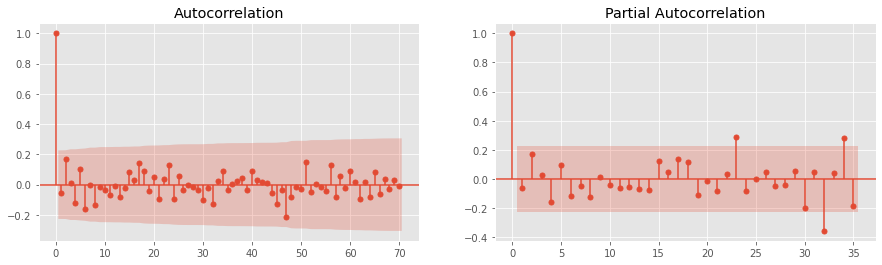

In [95]:
# SARIMAX AC and PAC with optimized parameters
mod = sm.tsa.statespace.SARIMAX(train, order=(0, 1, 2), seasonal_order=(1, 1, 2, 6)).fit(max_iter=50, method='powell')

resid = mod.resid

fig, ax = plt.subplots(1, 2, figsize=(15,4))
fig = sm.graphics.tsa.plot_acf(resid, lags=70, ax=ax[0])

fig = sm.graphics.tsa.plot_pacf(resid, lags=35, ax=ax[1])
#plt.show()
plt.savefig('images/AC_PAC_functions.png')

<h4>Train model on training set</h4>

In [96]:
# SARIMA with optimized parameters
mod = sm.tsa.statespace.SARIMAX(train, order=(0, 1, 2), seasonal_order=(2, 1, 1, 4))
res = mod.fit(max_iter=50, method='powell')
res
print(res.summary())

# (0, 1, 2), seasonal_order=(2, 1, 1, 4)
# SARIMAX(0, 1, 2),(1, 1, 2, 6) - AIC:832.7026273809294

/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: 5.686837
         Iterations: 5
         Function evaluations: 384
                                      SARIMAX Results                                      
Dep. Variable:                      avg_kwh_capita   No. Observations:                   75
Model:             SARIMAX(0, 1, 2)x(2, 1, [1], 4)   Log Likelihood                -426.513
Date:                             Sun, 03 Jan 2021   AIC                            865.026
Time:                                     20:54:15   BIC                            878.517
Sample:                                          0   HQIC                           870.384
                                              - 75                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

<h4>Generate in-sample predictions from model</h4>

In [97]:
# generate in-sample predictions 
predictions = res.predict(start=76, end=95)

/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [98]:
predictions.head()

76    -40.407598
77   -180.302115
78    263.385649
79   -434.917512
80    131.011948
Name: predicted_mean, dtype: float64

In [99]:
cov_rem['avg_kwh_capita'].head()

Date
2012-01-31    1000.127850
2012-02-28     956.367278
2012-03-31     907.091925
2012-04-30    1023.898229
2012-05-31    1076.980665
Name: avg_kwh_capita, dtype: float64

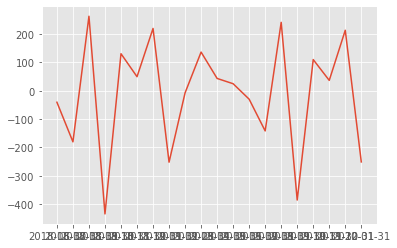

In [100]:
predictions = pd.DataFrame(predictions)
predictions.index = test.index

x = predictions.index

fig, ax = plt.subplots()
ax.plot(x, predictions)

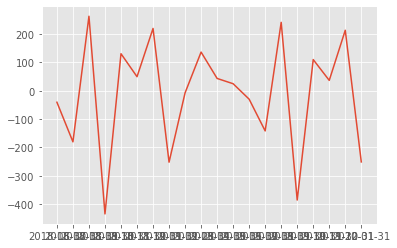

In [101]:
resid = pd.DataFrame(predictions)

x = resid.index

fig, ax = plt.subplots()
ax.plot(x, resid)

<h4>Generate inverse diff data for actual and predicted data</h4>

In [102]:
def inv_diff(df_orig_column ,df_diff_column, periods):
    # Generate np.array for the diff_inv function - it includes first n values(n = 
    # periods) of original data & further diff values of given periods
    value = np.array(df_orig_column[:periods].tolist()+df_diff_column[periods:].tolist())

    # Generate np.array with inverse diff
    inv_diff_vals = diff_inv(value, periods,1)[periods:]
    return inv_diff_vals

In [103]:
undiffed_preds = inv_diff(cov_rem['avg_kwh_capita'], predictions['predicted_mean'], 12)

In [104]:
undiffed_preds.shape

(20,)

In [105]:
undiffed_preds = pd.DataFrame(undiffed_preds)

<h4>Plot test data with predicted data</h4>

In [106]:
# create a data frame with predicted and actual values of undiffed data
undiffed_preds.reset_index(drop=True, inplace=True)
undiffed_preds.index=predictions.index
undiffed_preds['actual'] = cov_rem['avg_kwh_capita'][77:97]
undiffed_preds.head()
undiffed_preds.columns = ['predicted_mean', 'actual']

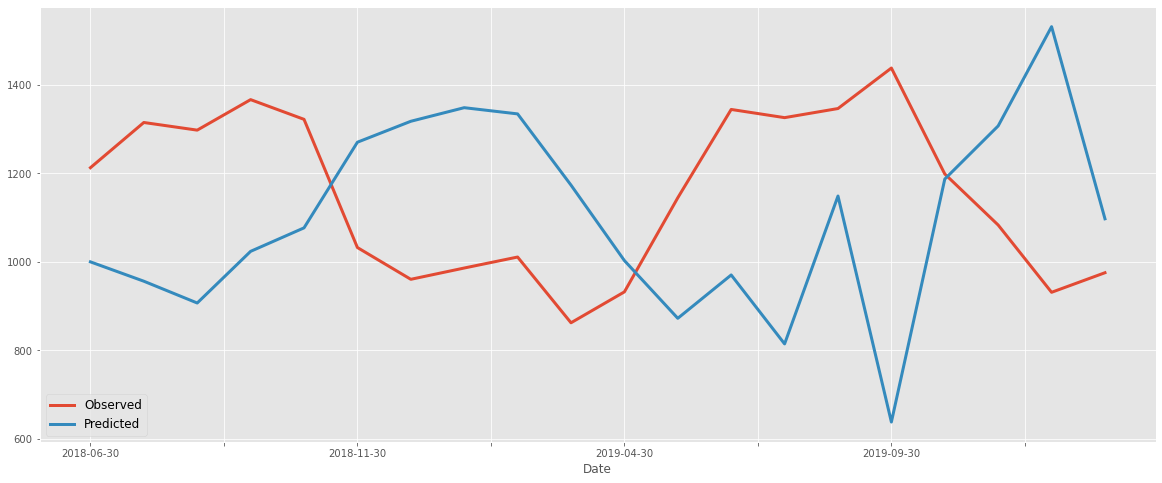

In [107]:
# plot test and pred data without differencing to see original unit scale

undiffed_preds['actual'].plot(figsize=(20,8), legend=True, linewidth=3.0)
undiffed_preds['predicted_mean'].plot(legend=True, linewidth=3.0, figsize=(20,8))

ax.set_title("Model Fit with Test Data", fontsize=18)
ax.set_xlabel('Date', fontsize='x-large')
ax.set_ylabel('Avg monthly kwh consumed', fontsize='x-large')
plt.legend(['Observed', 'Predicted'], loc=3, fontsize='large')
plt.savefig('images/test_pred_plot.png')

<h4>Plot predictions</h4>

/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


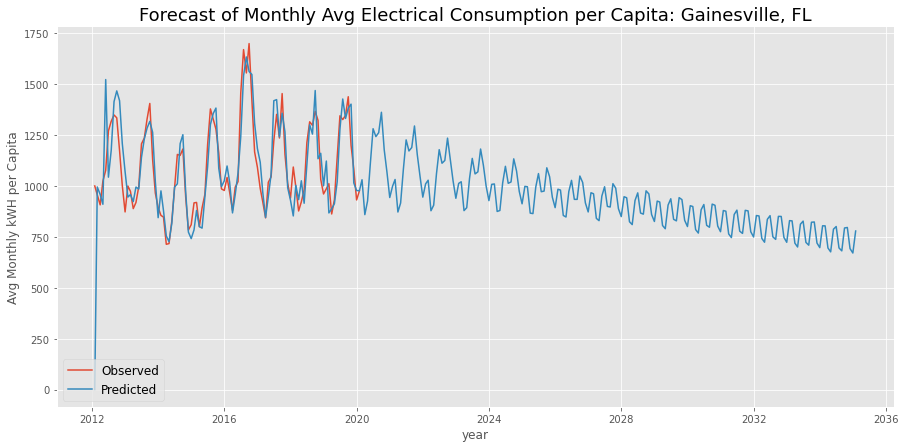

In [108]:
# Create a dataframe with index length of my prediction 
cov_rem.index = pd.to_datetime(cov_rem.index, infer_datetime_format=True)
index = pd.date_range(start='2020-02-28', end='2035-01-31', freq='M')
columns = ['avg_kwh_capita']
future_kwh = pd.DataFrame(index=index, columns=columns)

# Merge empty rediction df with the observed values df for endogenous factors in my model
future_kwh = future_kwh.merge(cov_rem, on='avg_kwh_capita', how='outer', left_index=True, right_index=True)

# Train a SARIMAX model with observed values 
e_consum_model = sm.tsa.statespace.SARIMAX(future_kwh, order=(0, 1, 2), seasonal_order=(2, 1, 1, 4)).fit()

# plot historical observations
fig, ax = plt.subplots(1, figsize=(15, 7))
ax.plot(future_kwh.index, future_kwh)

# generate predictions from the start of observed data to city goal period 
preds = e_consum_model.get_prediction(start='2012-01-31', end='2035-01-31')

ax.plot(future_kwh.index, preds.predicted_mean)
ax.set_title("Forecast of Monthly Avg Electrical Consumption per Capita: Gainesville, FL", fontsize=18)
ax.set_xlabel('year')
ax.set_ylabel('Avg Monthly kWH per Capita')
plt.legend(['Observed', 'Predicted'], loc=3, fontsize='large')
plt.savefig('images/pred_plot_diffed.png')

<h4>Plot a 95% confidence interval to 2035</h4

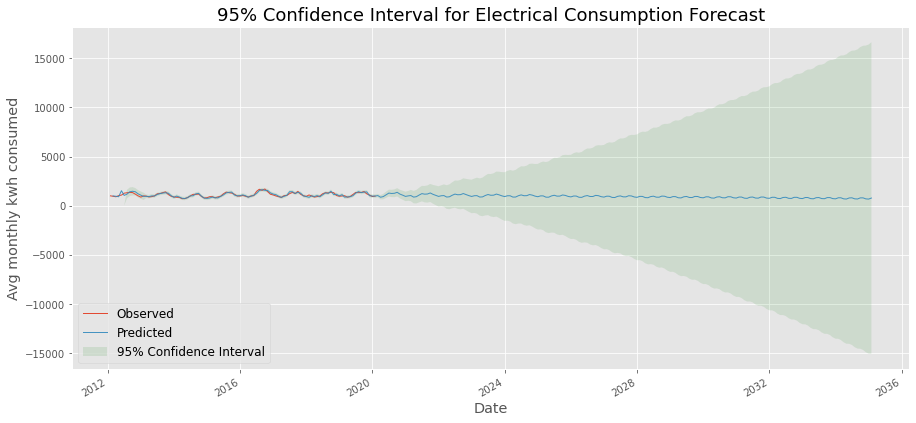

<Figure size 432x288 with 0 Axes>

In [21]:
# Generate plot of observed and predicted values with a 95% confidence interval

# specify number of forecasts
preds = e_consum_model.get_prediction(start='2012-02-28', end='2035-01-31')
pred_ci = preds.conf_int()
pred_ci = preds.conf_int()

# replace lower bound large confidence interval values with 0 to better visualize
pred_ci['lower avg_kwh_capita'][0] = 0
pred_ci['lower avg_kwh_capita'][1] = 0
pred_ci['lower avg_kwh_capita'][2] = 0
pred_ci['lower avg_kwh_capita'][3] = 0
pred_ci['lower avg_kwh_capita'][4] = 0

# replace upper bound large confidence interval values with 0 to better visualize
pred_ci['upper avg_kwh_capita'][0] = 0
pred_ci['upper avg_kwh_capita'][1] = 0
pred_ci['upper avg_kwh_capita'][2] = 0
pred_ci['upper avg_kwh_capita'][3] = 0
pred_ci['upper avg_kwh_capita'][4] = 0

ax = future_kwh['2012-01-31':].plot(label='observed', linewidth=1.0)
preds.predicted_mean.plot(ax=ax, label='Forecast', alpha=.9, figsize=(15, 7), linewidth=1.0,)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], facecolor='green', alpha=0.1)

ax.set_title("95% Confidence Interval for Electrical Consumption Forecast", fontsize=18)
ax.set_xlabel('Date', fontsize='x-large')
ax.set_ylabel('Avg monthly kwh consumed', fontsize='x-large')
plt.legend(['Observed', 'Predicted', '95% Confidence Interval'], loc=3, fontsize='large')

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('images/zoom_out_ci_diffed.png', dpi=100)

<h4>Plot a 95% confidence interval to 2022</h4

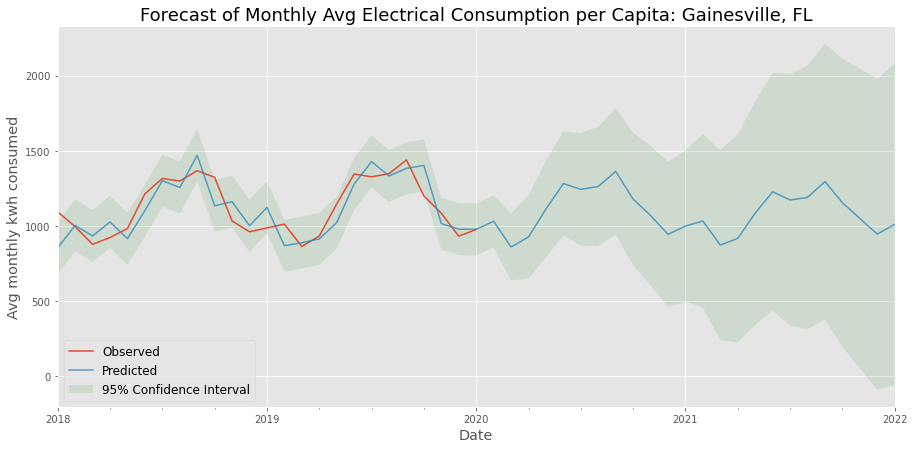

<Figure size 432x288 with 0 Axes>

In [42]:
# Zoom in where confidence interval more closely follows predictions

# specify number of forecasts
preds = e_consum_model.get_prediction(start='2018-01-31', end='2022-01-31', dynamic=False)
pred_ci = preds.conf_int()
pred_ci = preds.conf_int()


ax = future_kwh['2018-01-31': '2022-01-31'].plot(label='observed')
preds.predicted_mean.plot(ax=ax, label='Forecast', alpha=.8, figsize=(15, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], facecolor='green', alpha=0.1)

ax.set_title("Forecast of Monthly Avg Electrical Consumption per Capita: Gainesville, FL", fontsize=18)
ax.set_xlabel('Date', fontsize='x-large')
ax.set_ylabel('Avg monthly kwh consumed', fontsize='x-large')
plt.legend(['Observed', 'Predicted', '95% Confidence Interval'], loc=3, fontsize='large')

fig1 = plt.gcf()
plt.savefig('images/pred_2022_diffed.png')
plt.show()
plt.draw()


<h4>Create a feature column for monthly average emissions per capita for 2020 to 2022</h4>

In [109]:
# Carbon intensity for grid electricity is 0.93184 lb/kwh
preds = preds.predicted_mean
preds = preds.to_frame()
preds_CO2 = preds
preds_CO2['avg_CO2_capita'] = preds_CO2['predicted_mean']*0.93184

In [110]:
# drop predicted electrcity consumption column
preds_CO2 = preds_CO2.drop(columns='predicted_mean')

<h4>Create a feature column for monthly average electrcity cost per capita 2020 to 2022</h4>

In [111]:
# Grid electricity cost in Gainesville is $.1293/kWh
preds_cost = preds
preds_cost['avg_cost_capita'] = preds['predicted_mean']*0.1293

In [112]:
# remove other columns
preds_cost = preds_cost.drop(columns=['predicted_mean','avg_CO2_capita'])

In [120]:
preds_cost.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 277 entries, 2012-01-31 to 2035-01-31
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   avg_cost_capita  277 non-null    float64
dtypes: float64(1)
memory usage: 4.3 KB


<h4>Plot monthly average emissions per capita 2020 to 2022</h4>

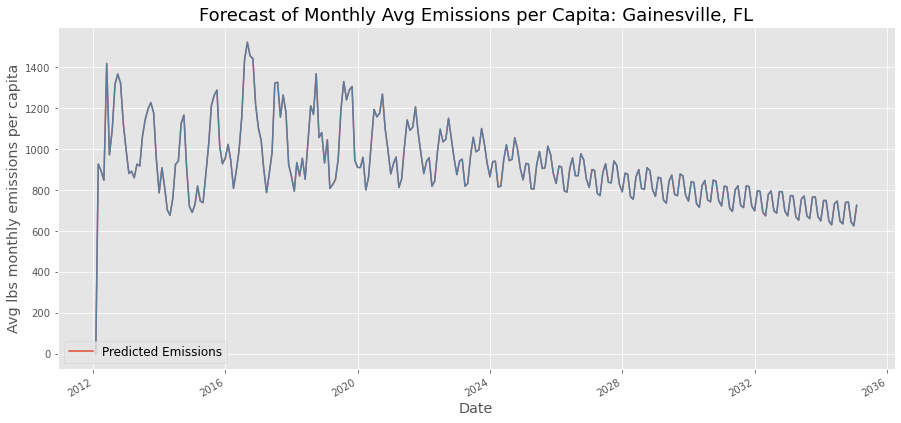

<Figure size 432x288 with 0 Axes>

In [113]:
# Zoom in where confidence interval more closely follows predictions

# specify number of forecasts
# preds = e_consum_model.get_prediction(start='2018-01-31', end='2022-01-31', dynamic=False)
# pred_ci = preds.conf_int()
# pred_ci = preds.conf_int()


ax = preds_CO2.plot(label='avg_CO2_capita')
preds_CO2.plot(ax=ax, label='Forecast', alpha=.8, figsize=(15, 7))
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], facecolor='green', alpha=0.1)

ax.set_title("Forecast of Monthly Avg Emissions per Capita: Gainesville, FL", fontsize=18)
ax.set_xlabel('Date', fontsize='x-large')
ax.set_ylabel('Avg lbs monthly emissions per capita', fontsize='x-large')
plt.legend(['Predicted Emissions'], loc=3, fontsize='large')

fig1 = plt.gcf()
plt.savefig('images/BAU_pred_emissions_2022.png')
plt.show()
plt.draw()


<h4>Plot monthly average grid-electricity cost per capita 2020 to 2022</h4>

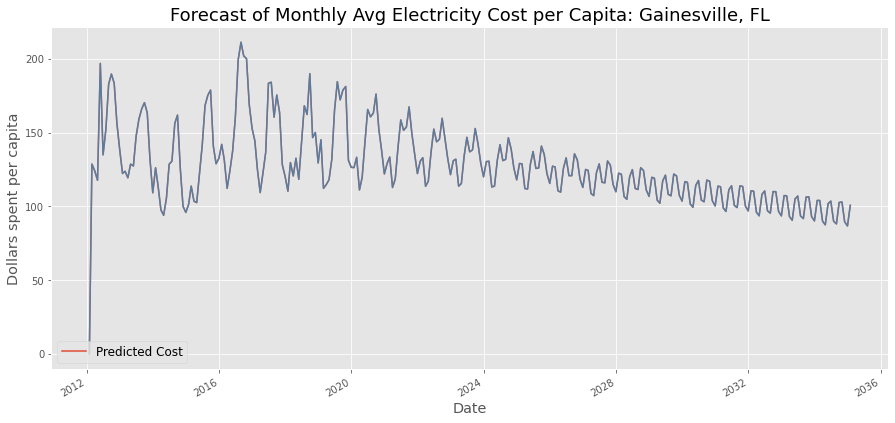

<Figure size 432x288 with 0 Axes>

In [114]:
# Zoom in where confidence interval more closely follows predictions

# specify number of forecasts
# preds = e_consum_model.get_prediction(start='2018-01-31', end='2022-01-31', dynamic=False)
# pred_ci = preds.conf_int()
# pred_ci = preds.conf_int()


ax = preds_cost.plot(label='avg_cost_capita')
preds_cost.plot(ax=ax, label='Forecast', alpha=.8, figsize=(15, 7))
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], facecolor='green', alpha=0.1)

ax.set_title("Forecast of Monthly Avg Electricity Cost per Capita: Gainesville, FL", fontsize=18)
ax.set_xlabel('Date', fontsize='x-large')
ax.set_ylabel('Dollars spent per capita', fontsize='x-large')
plt.legend(['Predicted Cost'], loc=3, fontsize='large')

fig1 = plt.gcf()
plt.savefig('images/BAU_pred_cost_2022.png')
plt.show()
plt.draw()


<h4>Generate ee improvements at different rates</h4>

In [123]:
future_ee_reduct = preds['predicted_mean']

TypeError: 'PredictionResultsWrapper' object is not subscriptable

In [122]:
# add a column the length of my input data
pd.set_option('display.max_rows', None)
ee_reduction_2035 = 0.5

no_reductions = np.zeros(96)
ee_reductions = np.linspace(1, ee_reduction_2035, 181)
full_len = np.concatenate((no_reductions, ee_reductions), axis=0)
future_ee_reduct['0.5_ee_reduction'] = full_len
future_ee_reduct

TypeError: 'PredictionResultsWrapper' object does not support item assignment